---
title: Analysing reddit data - part 4: data analysis  
date: 2015-12-09  
comments: false  
tags: Python, Programming tips, Public Data, Reddit API, pandas  
keywords: python, programming, reproducible research  

---

This week ends a 4-part series on extracting and analysing JSON-encoded data from reddit, using the subreddit [/r/relationships](https://www.reddit.com/r/relationships#hme) as an example. In the first two entries I [set up the environment]({filename}2015-11-18-reddit-api-part-1.md) and [collected the data]({filename}2015-11-25-reddit-api-part-2.md). [Last week]({filename}2015-12-02-reddit-api-part-3.md), I finished by cleaning the data and doing some basic analyses. This week we'll finish with some fairly simple bivariate analyses. We'll answer some questions about both posters to the subreddit and how the readers react to these posts. In the interest of brevity (i.e., not having to check parametric assumptions), I'll be using non-parametric tests, but if you were doing this as a formal analysis it would be necessary to complete all of these checks and consider the use of parametric tests.

## Questions about posters to the subreddit

Let's start by testing some hypotheses about the posters to the site. As we have the sex of the posters, the questions that immediately jump out at me is whether sex interacts with age and the type of posts (flairs) that are posted to the subreddit.

### Does the age distribution vary by sex?

The first question I will explore is whether the age distribution of the posters differs between the sexes. To start, I'll compute the median age of both men and women.

In [1]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd

rel_df = pd.read_csv("example.csv", header=0, index_col=0, parse_dates=True)
rel_df[:5]

,Date,Title,Flair,Comments,Score,PosterAge,PosterSex,DayOfWeek
0,2015-08-21 20:07:02,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,Updates,910,7885,26,F,Fri
1,2015-08-07 15:50:46,Update: I [30 F] am sitting in the back of my ...,Updates,629,6078,30,F,Fri
2,2015-06-23 02:20:34,UPDATE: My fiancee (24F) has no bridesmaids an...,Updates,623,5565,25,M,Tues
3,2015-08-01 01:38:10,My [42M] daughter [17F] has been bullying a gi...,NaN,970,5325,42,M,Sat
4,2015-08-25 22:51:57,[Update] My [26F] fiance's [28M] ex-wife [28F]...,Updates,765,5201,26,F,Tues


In [2]:
rel_df['PosterAge'].groupby([rel_df['PosterSex']]).median()

PosterSex
F    26
M    27
Name: PosterAge, dtype: float64

Hmmm, it looks like there might be a difference there, with male posters older than female posters. To test this, I construct a hypothesis that men are significantly older than women (at the 0.05 level). I can assess this using a Wilcoxon rank-sum test, which is given by the `ranksums` [function](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.ranksums.html) in the `scipy.stats` package. As I'm predicting that one group is larger than another I should use a one-sided test, so I divide the returned p-value by 2.

In [3]:
from scipy import stats  

d = {}
for key, value in rel_df.groupby('PosterSex'):
        d['%s' % key] = value['PosterAge']

u_stat, p_val = stats.ranksums(d['M'], d['F'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (u_stat, p_val / 2)

The test statistic is 2.745, and the significance level is 0.003.


You can see that the p-value is 0.003, meaning male posters are significantly older than female posters.

### Does flair type differ by sex?

Another interesting question is whether the flair differs by sex, or in other words, does the type of questions asked on the subreddit differ for men and women? We'll start by looking at the frequencies of posts for each sex by flair. As mentioned in the [previous post]({filename}2015-12-02-reddit-api-part-3.md), we won't be using the flairs "Breakups", "Personal issues" or "Dating" due to the small number of posts in these categories.

In [4]:
sex_flair = pd.crosstab(rel_df['Flair'], rel_df['PosterSex'], 
            rownames = ['Flair'], colnames=['Poster Sex']).ix[
    ['Infidelity', 'Non-Romantic', 'Relationships', 'Updates']]
sex_flair

Poster Sex,F,M
Flair,,
Infidelity,13,17
Non-Romantic,107,41
Relationships,85,68
Updates,281,175


Well, that's not the most informative table. As there are an unequal number of men and women in the sample, we need to standardise these categories in some way. The most logical way is to look at percentage of posts in each column:

In [5]:
sex_flair.apply(lambda c: c/c.sum() * 100, axis=0)

Poster Sex,F,M
Flair,,
Infidelity,2.674897,5.647841
Non-Romantic,22.016461,13.621262
Relationships,17.489712,22.591362
Updates,57.818930,58.139535


Ah ha! Now we can see that we have two flairs that may differ by sex: women are more likely to questions about non-romantic relationships, whereas men are more likely to ask questions about romantic relationships. Let's test this more formally. The test we would use here is a [Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test), which can be performed in Python using the `stats.chi2_contingency` [function](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html).

In [6]:
chi2, p_val, df, exp_vals = stats.chi2_contingency(sex_flair)
print "The test statistic is %1.3f, and the significance level is %1.3f." % (chi2, p_val)

The test statistic is 13.768, and the significance level is 0.003.


Again, we can see that the test is significant, with a p-value of 0.003. What this tells us is that the observed frequencies in our contingency table between flair and sex is different from what would be expected if the two variables do not have a relationship. Therefore, we know that the sex of the poster significantly affects what kind of topics they post about. However, I should stress that as this is an omnibus test we can't say specifically that men and women differ in how frequently they post about non-romantic and relationships topics; we'd need further (post-hoc) testing for that.

## Questions about the readers of the subreddit

Now that we've had a brief look at the posters to the subreddit, let's have a look at how posters in the subreddit behave. This time, let's have a look at the `DayOfWeek`, `Score` and `Comments` variables. More specifically, let's have a look at whether the overall post score and number of comments it attracts differs by the day of the week it is posted. To start, let's look at the median score and comments per day of the week:

In [7]:
score_com_day = rel_df.groupby('DayOfWeek')[
    ['Score', 'Comments']].median()
score_com_day = score_com_day.reindex(['Mon', 'Tues', 'Weds', 
                                       'Thurs', 'Fri', 'Sat', 
                                       'Sun'])
score_com_day

,Score,Comments
DayOfWeek,,
Mon,1241.0,241.5
Tues,1260.5,272.0
Weds,1248.0,312.0
Thurs,1120.0,281.0
Fri,1324.0,271.0
Sat,1293.0,268.0
Sun,1237.0,249.0


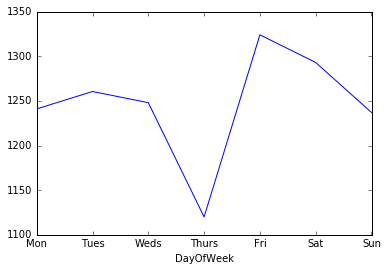

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plot = score_com_day['Score'].plot()
fig = plot.get_figure()
fig.savefig("score_plot.png", dpi=400, bbox_inches='tight')

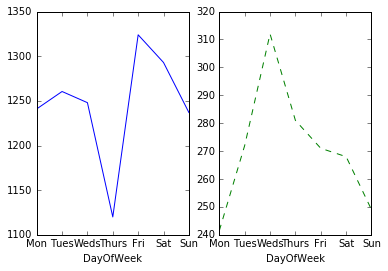

In [53]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
score_com_day['Score'].plot()

ax2 = fig.add_subplot(1, 2, 2)
score_com_day['Comments'].plot(linestyle='--', color='g')

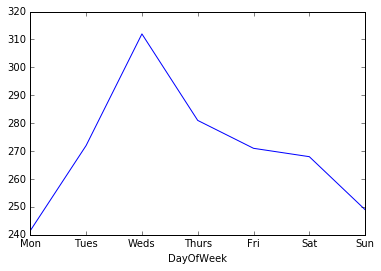

In [15]:
score_com_day['Comments'].plot()

In [12]:
d = {}
for key, value in rel_df.groupby('DayOfWeek'):
        d['%s' % key] = value['Score']
        
H, p_val = stats.mstats.kruskalwallis(d['Mon'], d['Tues'], d['Weds'], d['Thurs'], 
                                       d['Fri'], d['Sat'], d['Sun'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 11.280, and the significance level is 0.080.


In [13]:
d = {}
for key, value in rel_df.groupby('DayOfWeek'):
        d['%s' % key] = value['Comments']
        
H, p_val = stats.mstats.kruskalwallis(d['Mon'], d['Tues'], d['Weds'], d['Thurs'], 
                                       d['Fri'], d['Sat'], d['Sun'])
print "The test statistic is %1.3f, and the significance level is %1.3f." % (H, p_val)

The test statistic is 13.387, and the significance level is 0.037.


### Poster behaviour
- Does the age distribution vary for men and women? (Chi-sq)
- Are certain topics more likely on different days of the week? (Chi-sq)

### Reader behaviour
- Are certain topics more popular (higher score and more comments)
- Are certain days of the week more popular (higher score and more comments)

## Interpretations and bias
- These are only the most popular posts, so they are not representative of the general pattern of behaviour on the site.
- Possible sources of bias include missing data on flairs (and decision to replace flairs may have increased that bias as data for the rest of the flairs is still missing), and missing sex and age information. There may be characteristics about people who don't format their titles properly (with suggested age/sex format) and the type of post (more distressed, possibly?).